In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

### References
- Keras tutorial: https://keras.io/examples/vision/super_resolution_sub_pixel/
- LearnOpenCV tutorial: https://learnopencv.com/super-resolution-in-opencv/

In [2]:
def add_zoom(img, ax):
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False),plt.xticks(visible=False)
    return axins

def plot_results(img1, img2):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10), dpi = 200)
    ax1.imshow(img1[::-1], origin="lower"), ax1.set_title('Original')
    ax2.imshow(img2[::-1], origin="lower"), ax2.set_title('High Resolution')

    axins_1 = add_zoom(img1, ax1)
    axins_2 = add_zoom(img2, ax2)

    # Make the line.
    mark_inset(ax1, axins_1, loc1=1, loc2=3, fc="none", ec="blue")
    mark_inset(ax2, axins_2, loc1=1, loc2=3, fc="none", ec="blue")
    # plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

In [3]:
video_path = 'videos/Chrono Cross Cena Seguinte.mp4'
scale = 2

In [6]:
def start_dnn_superres(scale):
    sr = cv.dnn_superres.DnnSuperResImpl_create()
    path = "models/ESPCN_x{}.pb".format(str(scale))
    sr.readModel(path)
    sr.setModel("espcn",scale)
    return sr

def get_quality_values(orig, upsampled):
    psnr = cv.PSNR(upsampled, orig)    
    ssim = compare_ssim(upsampled, orig, multichannel=True)
    # print("PSNR: {}, SSIM: {}".format(psnr, ssim))
    return (psnr, ssim)

sr = start_dnn_superres(scale)
video_h, video_w = 600, 800

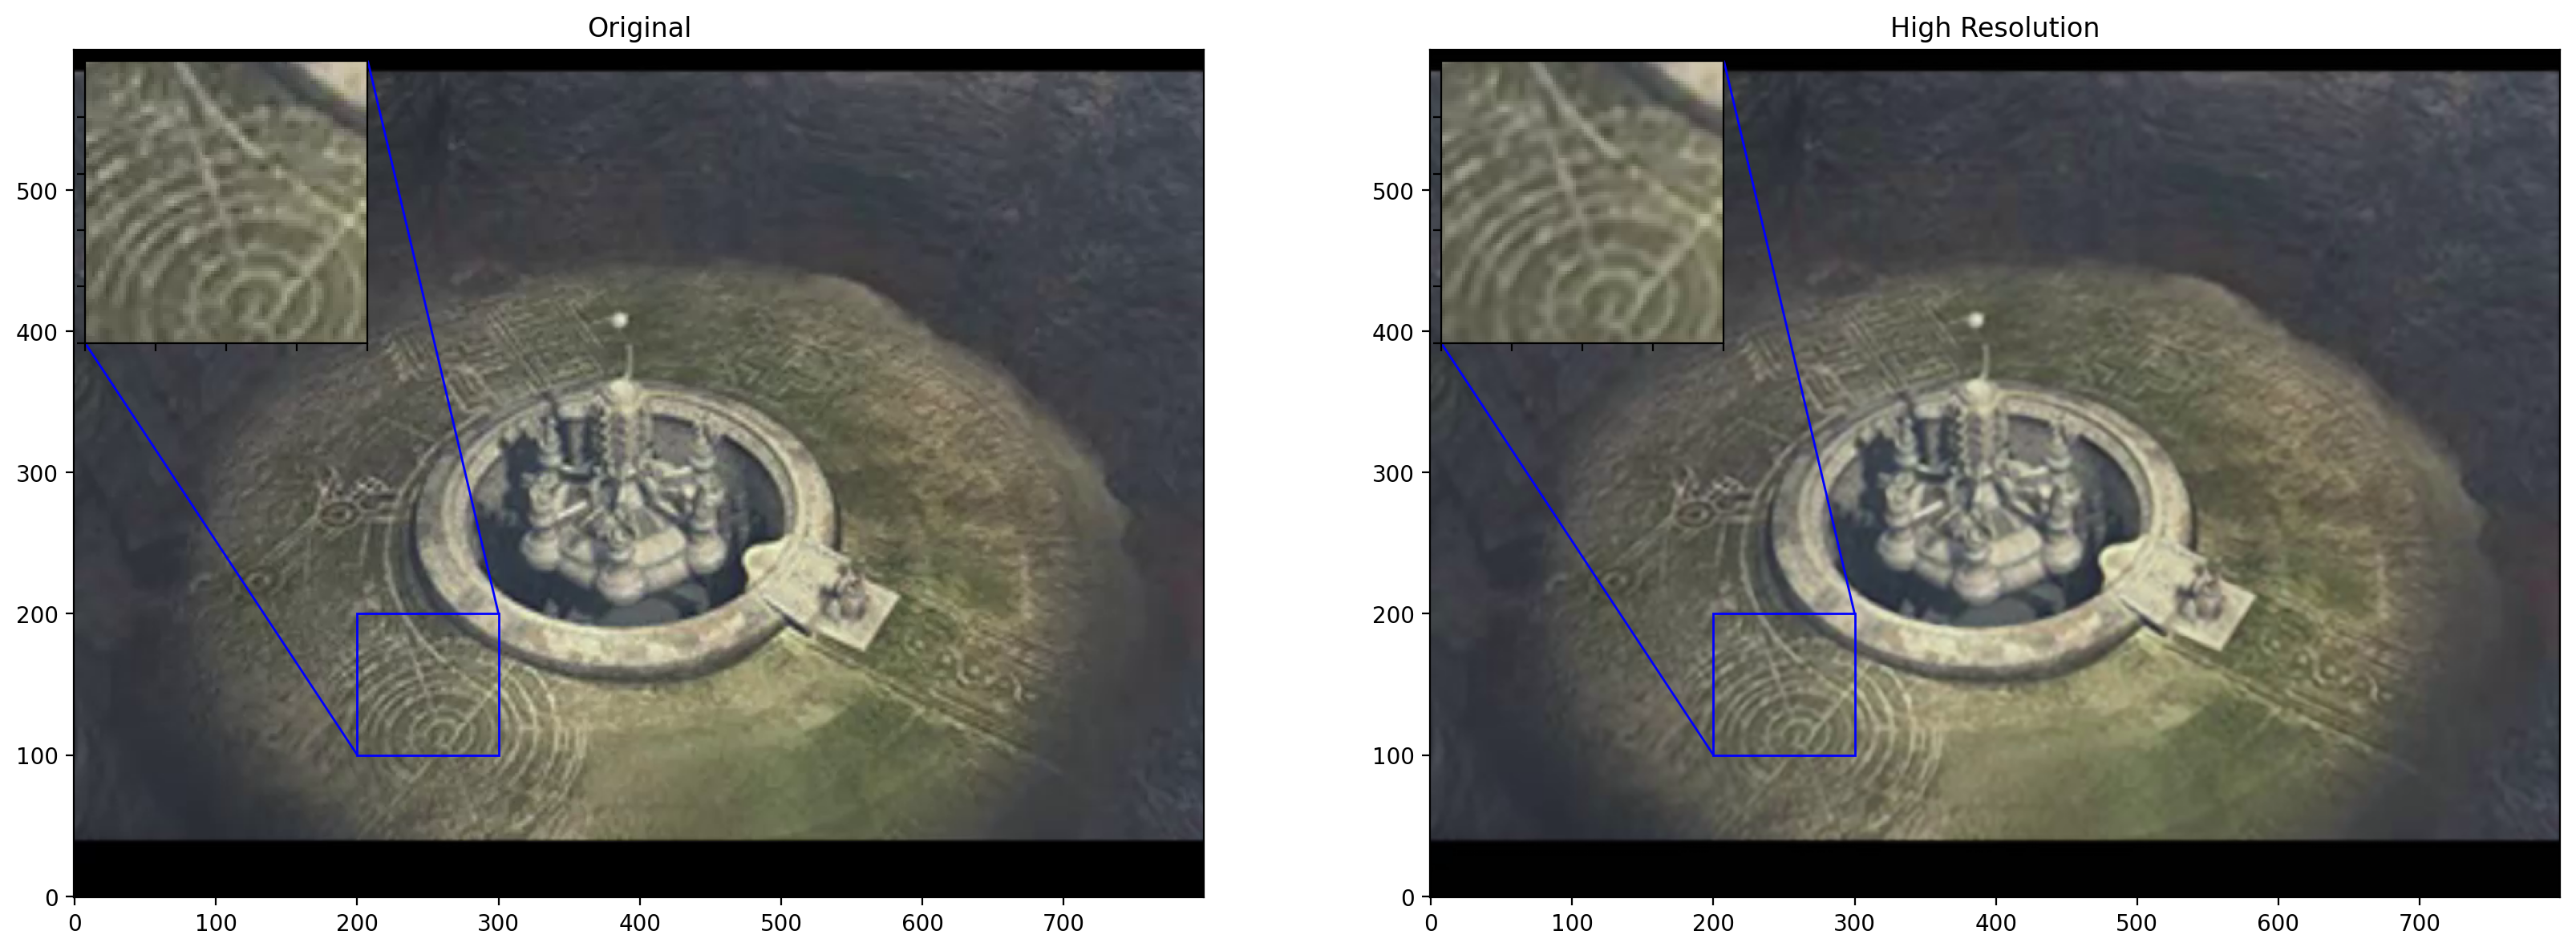

Avg. PSNR of low resolution images is 0.0397
Avg. PSNR of reconstructions is 0.0417
Avg. SSIM of low resolution images is 0.0010
Avg. SSIM of reconstructions is 0.0010


In [11]:
capture = cv.VideoCapture(video_path)
if not capture.isOpened():
    print("Cannot open video")
    exit()

total_bicubic_psnr, total_test_psnr = 0.0, 0.0
total_bicubic_ssim, total_test_ssim = 0.0, 0.0
number_of_frames = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
i = 0
# Define the codec and create VideoWriter object
fourcc = cv.VideoWriter_fourcc(*'XVID')
write_video = cv.VideoWriter('prediction.avi', fourcc, 20.0, (video_h,  video_w))

while capture.isOpened():
    ret, frame = capture.read()
    if not ret:
        print("Can't read frame")
        break
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB) # cv.COLOR_BGR2GRAY

    lowres_input = cv.resize(frame, None, fx=1.0/scale, fy=1.0/scale, interpolation=cv.INTER_AREA) # scale 2 = reduce img (300, 400, 3)
    w = lowres_input.shape[1] * scale
    h = lowres_input.shape[0] * scale
    highres_img = cv.resize(frame, (w, h), cv.INTER_CUBIC)
    prediction = sr.upsample(lowres_input)
    lowres_img = cv.resize(lowres_input, (w, h), cv.INTER_CUBIC) # scale 2 = (600, 800, 3)

    bicubic_psnr, bicubic_ssim = get_quality_values(lowres_img, highres_img)
    test_psnr, test_ssim = get_quality_values(prediction, highres_img)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr
    total_bicubic_ssim += bicubic_ssim
    total_test_ssim += test_ssim

    if i == 500:
        plot_results(frame, prediction)
    i += 1
    plot_results(frame, prediction)
    # print(i, end=', ')

    # write_video.write(prediction)
    break

capture.release()
write_video.release()
cv.destroyAllWindows()

print("Avg. PSNR of low resolution images is {:.4f}".format((total_bicubic_psnr / number_of_frames)))
print("Avg. PSNR of reconstructions is {:.4f}".format((total_test_psnr / number_of_frames)))
print("Avg. SSIM of low resolution images is {:.4f}".format((total_bicubic_ssim / number_of_frames)))
print("Avg. SSIM of reconstructions is {:.4f}".format((total_test_ssim / number_of_frames)))